# Reproduce original VGAE (Kipf & Welling 2016) Cora embeddings

## Run the original training code (corrected to run inside Jupyter)

It trains embeddings using the `adj_train` adjacency, where ~15% of the edges have been removed (10% for a test set, 5% for a validation set).

In [1]:
import time
import os

# Train on CPU (hide GPU) due to memory constraints
os.environ['CUDA_VISIBLE_DEVICES'] = ""

import tensorflow as tf
import numpy as np
import scipy.sparse as sp

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

from gae.optimizer import OptimizerAE, OptimizerVAE
from gae.input_data import load_data
from gae.model import GCNModelAE, GCNModelVAE
from gae.preprocessing import preprocess_graph, construct_feed_dict, sparse_to_tuple, mask_test_edges

In [2]:
# Set options and move to necessary directory for data loading
MODEL_STRING = 'gcn_vae'
os.chdir('../../gae')

In [3]:
# Settings
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
flags.DEFINE_integer('epochs', 200, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 32, 'Number of units in hidden layer 1.')
flags.DEFINE_integer('hidden2', 16, 'Number of units in hidden layer 2.')
flags.DEFINE_float('weight_decay', 0., 'Weight for L2 loss on embedding matrix.')
flags.DEFINE_float('dropout', 0., 'Dropout rate (1 - keep probability).')

flags.DEFINE_string('model', MODEL_STRING, 'Model string.')
flags.DEFINE_string('dataset', 'cora', 'Dataset string.')
flags.DEFINE_integer('features', 1, 'Whether to use features (1) or not (0).')

# Workaround for Jupyter having an '-f' flag in its sys.argv -- this is ignored
tf.app.flags.DEFINE_string('f', '', 'kernel')

In [4]:
model_str = FLAGS.model
dataset_str = FLAGS.dataset

# Load data
adj, features = load_data(dataset_str)

# Store original adjacency matrix (without diagonal entries) for later
adj_orig = adj
adj_orig = adj_orig - sp.dia_matrix((adj_orig.diagonal()[np.newaxis, :], [0]), shape=adj_orig.shape)
adj_orig.eliminate_zeros()

adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = mask_test_edges(adj)
adj = adj_train

if FLAGS.features == 0:
    features = sp.identity(features.shape[0])  # featureless

# Some preprocessing
adj_norm = preprocess_graph(adj)

# Define placeholders
placeholders = {
    'features': tf.sparse_placeholder(tf.float32),
    'adj': tf.sparse_placeholder(tf.float32),
    'adj_orig': tf.sparse_placeholder(tf.float32),
    'dropout': tf.placeholder_with_default(0., shape=())
}

num_nodes = adj.shape[0]

features = sparse_to_tuple(features.tocoo())
num_features = features[2][1]
features_nonzero = features[1].shape[0]

In [5]:
# Create model
model = None
if model_str == 'gcn_ae':
    model = GCNModelAE(placeholders, num_features, features_nonzero)
elif model_str == 'gcn_vae':
    model = GCNModelVAE(placeholders, num_features, num_nodes, features_nonzero)

pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)

# Optimizer
with tf.name_scope('optimizer'):
    if model_str == 'gcn_ae':
        opt = OptimizerAE(preds=model.reconstructions,
                          labels=tf.reshape(tf.sparse_tensor_to_dense(placeholders['adj_orig'],
                                                                      validate_indices=False), [-1]),
                          pos_weight=pos_weight,
                          norm=norm)
    elif model_str == 'gcn_vae':
        opt = OptimizerVAE(preds=model.reconstructions,
                           labels=tf.reshape(tf.sparse_tensor_to_dense(placeholders['adj_orig'],
                                                                       validate_indices=False), [-1]),
                           model=model, num_nodes=num_nodes,
                           pos_weight=pos_weight,
                           norm=norm)

In [6]:
def get_roc_score(edges_pos, edges_neg, emb=None):
    if emb is None:
        feed_dict.update({placeholders['dropout']: 0})
        emb = sess.run(model.z_mean, feed_dict=feed_dict)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    # Predict on test set of edges
    adj_rec = np.dot(emb, emb.T)
    preds = []
    pos = []
    for e in edges_pos:
        preds.append(sigmoid(adj_rec[e[0], e[1]]))
        pos.append(adj_orig[e[0], e[1]])

    preds_neg = []
    neg = []
    for e in edges_neg:
        preds_neg.append(sigmoid(adj_rec[e[0], e[1]]))
        neg.append(adj_orig[e[0], e[1]])

    preds_all = np.hstack([preds, preds_neg])
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)

    return roc_score, ap_score

In [7]:
# Initialize session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

cost_val = []
acc_val = []
val_roc_score = []

adj_label = adj_train + sp.eye(adj_train.shape[0])
adj_label = sparse_to_tuple(adj_label)

In [8]:
# Train model
for epoch in range(FLAGS.epochs):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(adj_norm, adj_label, features, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})
    # Run single weight update
    outs = sess.run([opt.opt_op, opt.cost, opt.accuracy], feed_dict=feed_dict)

    # Compute average loss
    avg_cost = outs[1]
    avg_accuracy = outs[2]

    roc_curr, ap_curr = get_roc_score(val_edges, val_edges_false)
    val_roc_score.append(roc_curr)

    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(avg_cost),
          "train_acc=", "{:.5f}".format(avg_accuracy), "val_roc=", "{:.5f}".format(val_roc_score[-1]),
          "val_ap=", "{:.5f}".format(ap_curr),
          "time=", "{:.5f}".format(time.time() - t))

print("Optimization Finished!")

roc_score, ap_score = get_roc_score(test_edges, test_edges_false)
print('Test ROC score: ' + str(roc_score))
print('Test AP score: ' + str(ap_score))

Epoch: 0001 train_loss= 1.73630 train_acc= 0.49758 val_roc= 0.69637 val_ap= 0.72964 time= 0.53998
Epoch: 0002 train_loss= 1.49256 train_acc= 0.48150 val_roc= 0.67368 val_ap= 0.71469 time= 0.30793
Epoch: 0003 train_loss= 1.35401 train_acc= 0.43786 val_roc= 0.66828 val_ap= 0.71010 time= 0.29184
Epoch: 0004 train_loss= 1.26553 train_acc= 0.39009 val_roc= 0.66880 val_ap= 0.71298 time= 0.31090
Epoch: 0005 train_loss= 1.15006 train_acc= 0.34375 val_roc= 0.67860 val_ap= 0.71969 time= 0.36988
Epoch: 0006 train_loss= 1.04785 train_acc= 0.34228 val_roc= 0.69820 val_ap= 0.73002 time= 0.27514
Epoch: 0007 train_loss= 0.94884 train_acc= 0.33588 val_roc= 0.72446 val_ap= 0.74617 time= 0.29884
Epoch: 0008 train_loss= 0.86441 train_acc= 0.34592 val_roc= 0.76278 val_ap= 0.77416 time= 0.27687
Epoch: 0009 train_loss= 0.79288 train_acc= 0.36035 val_roc= 0.79038 val_ap= 0.79671 time= 0.31811
Epoch: 0010 train_loss= 0.72303 train_acc= 0.37749 val_roc= 0.79157 val_ap= 0.79932 time= 0.30188
Epoch: 0011 train_lo

## Plot the embeddings

In [9]:
import pickle

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.manifold import MDS

In [10]:
# Compute embeddings
feed_dict = construct_feed_dict(adj_norm, adj_label, features, placeholders)
feed_dict.update({placeholders['dropout']: 0})
emb = sess.run(model.z_mean, feed_dict=feed_dict)

In [11]:
# Downscale the embeddings
mds = MDS(n_jobs=-2)
mds.fit(emb)

MDS(dissimilarity='euclidean', eps=0.001, max_iter=300, metric=True,
  n_components=2, n_init=4, n_jobs=-2, random_state=None, verbose=0)

In [12]:
# Load the ground truth labels

def parse_index_file(filename):
    index = []
    for line in open(filename):
        index.append(int(line.strip()))
    return index

ty = pickle.load(open("data/ind.cora.ty", 'rb'), encoding='latin1')
ally = pickle.load(open("data/ind.cora.ally", 'rb'), encoding='latin1')
test_idx_reorder = parse_index_file("data/ind.cora.test.index")
test_idx_range = np.sort(test_idx_reorder)

labels = sp.vstack((ally, ty)).toarray()
labels[test_idx_reorder, :] = labels[test_idx_range, :]

In [13]:
# Turn labels into colors
palette = sb.color_palette(n_colors=labels.shape[1])
colors = np.array(palette)[np.argmax(labels, axis=1)]

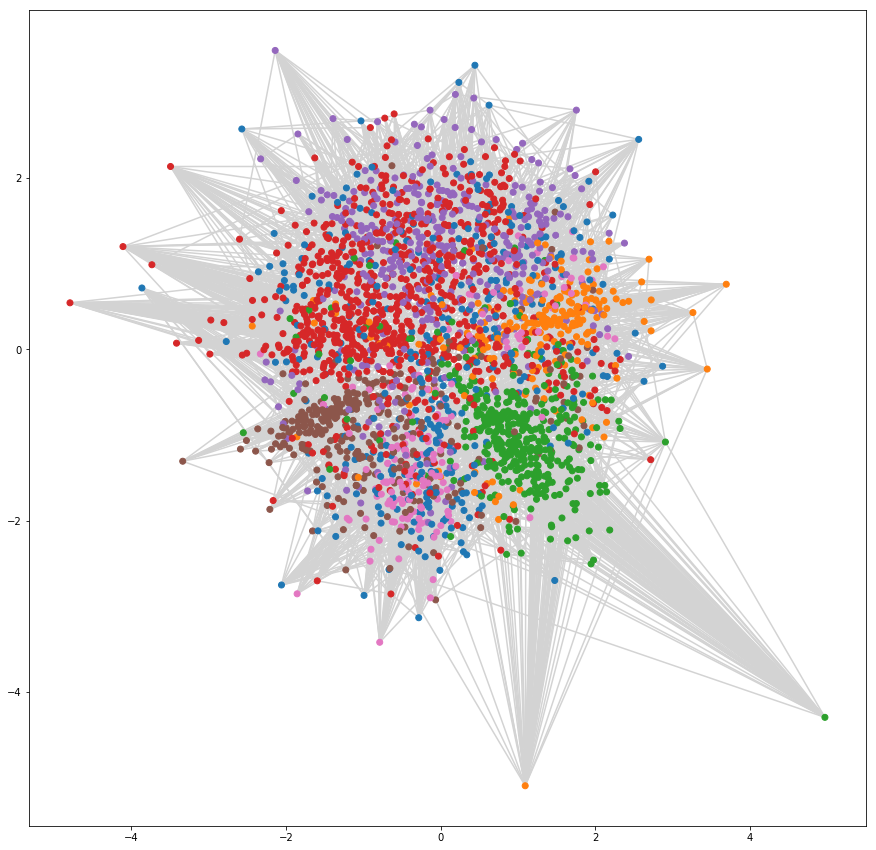

In [14]:
# Plot the downscaled embeddings and the links
fig, ax = plt.subplots(figsize=(15, 15))
edges = np.array([[mds.embedding_[i], mds.embedding_[j]] for (i, j) in sparse_to_tuple(sp.triu(adj))[0]])
edges = edges.transpose([2, 1, 0])
ax.plot(edges[0], edges[1], color='lightgrey', zorder=1)
ax.scatter(mds.embedding_[:, 0], mds.embedding_[:, 1], c=colors, zorder=2)